In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import ntpath

def BGR2RGB(img):
    RGB_image = img[...,::-1]
    return RGB_image

Step 1: calibrate camera, undistort images

In [2]:
def calibrate_camera(nx, ny):
    '''
    code adopted and based off of Udacity code sample for camera calibration
    creates two lists for cv2.calibrateCamera: @imgpoints and @ objpoints
    '''
    print('CALIBRATING IMAGES')
    SHOW_IMAGES = False #do not print images as function progresses

    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    #define lists for points
    objpoints = []
    imgpoints = []

    #list images
    images = glob.glob('camera_cal/*.jpg')

    #step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        print("Processing Image ", i)
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        #upon finding corners, add them to list
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if SHOW_IMAGES:
                cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
                plt.imshow(img)
                plt.show()
                
    return (objpoints, imgpoints)

In [3]:
objpoints, imgpoints = calibrate_camera(9, 6)

CALIBRATING IMAGES
Processing Image  0
Processing Image  1
Processing Image  2
Processing Image  3
Processing Image  4
Processing Image  5
Processing Image  6
Processing Image  7
Processing Image  8
Processing Image  9
Processing Image  10
Processing Image  11
Processing Image  12
Processing Image  13
Processing Image  14
Processing Image  15
Processing Image  16
Processing Image  17
Processing Image  18
Processing Image  19


In [4]:
def undistort(img, objpoints, imgpoints):
    '''
    accepts lists and image as input to calibrate and modify image
    '''
    
    #define image dimensions
    img_size = (img.shape[1], img.shape[0])
    
    #calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    #modify image
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    return img_undistorted 

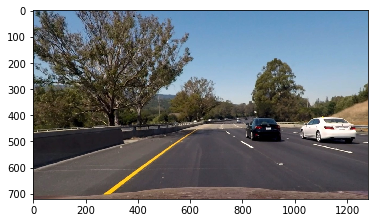

In [5]:
img_undistorted = undistort(cv2.imread('test_images/test6.jpg'), objpoints, imgpoints)
img_undistorted = img_undistorted[...,::-1]#reverse color codes from BGR to RGB
plt.imshow(img_undistorted)

#plt.imsave('output_images/undistorted_test6.jpg', img_undistorted)

Step 2: thresholds and binary image

In [6]:
def create_binary_image(img):
    
    #sobel Transformation
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    retval, sxthresh = cv2.threshold(scaled_sobel, 50, 150, cv2.THRESH_BINARY)
    sxbinary[(sxthresh >= 30) & (sxthresh <= 160)] = 1

    #color Transformation
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2] # get the S channel
    s_binary = np.zeros_like(s_channel) # initialize binary version
    s_thresh = cv2.inRange(s_channel.astype('uint8'), 170, 250) # sets to 255 if in range
    s_binary[(s_thresh == 255)] = 1 #normalize to 1 

    combined = np.zeros_like(gray)
    combined[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined

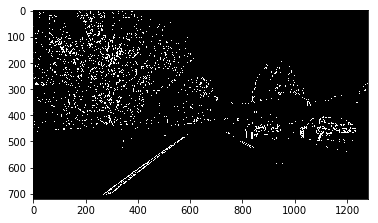

In [7]:
combined = create_binary_image(img_undistorted)
plt.imshow(combined, cmap='gray')

#plt.imsave('output_images/combined_binary_test6.jpg', combined, cmap='gray')

Step 3: Perspective Transform

In [8]:
def perspective_transform(img):
    #note: images are 720 x 1280
    
    #define rectangle for perspective transform
    src = np.float32([[240,720],[580,450],[710,450],[1160,720]])
    #define destination points
    dst =  np.float32([[300,720],[300,0],[900,0],[900,720]])

    M = cv2.getPerspectiveTransform(src, dst)
    
    transformed =cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return transformed

In [9]:
def inverse_perspective_transform(img):
    #note: images are 720 x 1280
    
    src = np.float32([[240,720],[580,450],[710,450],[1160,720]])

    dst =  np.float32([[300,720],[300,0],[900,0],[900,720]])

    #reverse output and input to achieve inverse
    M = cv2.getPerspectiveTransform(dst, src)

    inverse_transformed = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return inverse_transformed

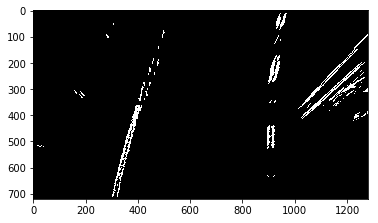

In [10]:
transformed = perspective_transform(combined)
plt.imshow(transformed, cmap='gray')

#plt.imsave('output_images/perspective_transform_test6.jpg', transformed, cmap='gray')

Step 4: determine lane lines from transform

In [11]:
def find_lanes(img):
    '''
    following code based off of improved_draw_lines from lane lines p1
    '''
    #initilize arrays to store found data
    left_fit , right_fit =[], []
    
    out_img = np.dstack((img, img, img))*255
    
    #use a histogram to discover data
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    #choose the number of sliding windows
    nwindows = 10

    #set height of windows
    window_size = np.int(img.shape[0]/nwindows)

    #identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    #current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    #set the width of the windows +/- margin
    margin = 100

    #set minimum number of pixels found to recenter window
    minpix = 50

    #create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #step through windows one by one
    for window in range(nwindows):
        #identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_size
        win_y_high = img.shape[0] - window*window_size
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        #draw windows on the visualization image      
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        #identify nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        #append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        #if found > minpix pixels, recenter next window on mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    #concatenate arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    #extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    #fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    #generate x and y values for plotting
    fity = np.linspace(0, img.shape[0]-1, img.shape[0] )
    fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
    fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return (fit_leftx, fit_rightx, fity, out_img)

In [22]:
left_fitx, right_fitx, yvals, out_img = find_lanes(transformed)
print(len(yvals))

720


In [13]:
def fit_lane(warped_img, undist, yvals, left_fitx, right_fitx):
    #create an image to draw lines on
    color_warp = np.dstack((warped_img, warped_img, warped_img))

    #recast the x and y points into a usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    #draw purple lane onto warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (100,0,255))

    #warp blank back to original image space using inverse perspective matrix (Minv)
    newwarp = inverse_perspective_transform(color_warp);
    
    #combine result with original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

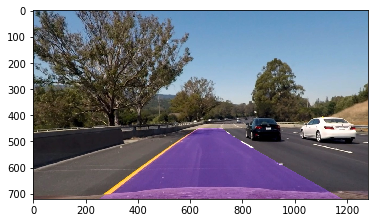

In [14]:
processed_image = fit_lane(transformed, img_undistorted, yvals, left_fitx, right_fitx)
plt.imshow(processed_image)

#plt.imsave('output_images/processed_image_test6.jpg', processed_image)

Step 5: Determine curvature

In [15]:
def get_statistics(leftx, rightx, ploty):
    
    ymeters_per_pix = 30/720 # meters per pixel in y dimension from udacity lesson
    xmeters_per_pix = 3.7/590 # meters per pixel in x dimension from udacity lesson

    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ymeters_per_pix, leftx*xmeters_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ymeters_per_pix, rightx*xmeters_per_pix, 2)



    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ymeters_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ymeters_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])



    # Write dist from center
    center = 1280./2
    lane_x = rightx - leftx
    center_x = (lane_x / 2.0) + leftx
    distance = (center_x - center) * xmeters_per_pix

    result = left_curverad, right_curverad, np.mean(distance * 100.0)
    
    return result

In [16]:
left_stats, right_stats, distance = get_statistics(left_fitx, right_fitx, yvals)
print(left_stats)
print(right_stats)

958.863353891
751.923157716


Step 6: display statistics on image frame by frame

In [17]:
def draw_stats_on_image(img, left_curvature, right_curvature, distance):
    
    direction = 'L' if distance < 0 else 'R'
    
    cv2.putText(img, 'Left Curvature Radius = %d(m)' % left_curvature, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Right Curvature Radius = %d(m)' % right_curvature, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(img, 'Distance from center = %d(cm) %s' % (np.absolute(distance), direction), (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
   
    return img;

In [18]:
statistics = draw_stat_on_image(processed_image, left_stats, right_stats, distance)
plt.imshow(statistics)

#plt.imsave('output_images/statistic_test6.jpg', statistics)

NameError: name 'draw_stat_on_image' is not defined

In [ ]:
def pipeline(img):
    '''
    Condensed version of all necessary steps to achieve an annotated image with the lane marked
    '''
    undistorted = undistort(img, objpoints, imgpoints)
    binarized = create_binary_image(undistorted)
    transformed = perspective_transform(binarized)

    left_fit, right_fit, yvals, out_img = find_lanes(transformed)
    lanes = fit_lane(transformed, undistorted, yvals, left_fit, right_fit)
    left_stats, right_stats, distance = get_statistics(left_fit, right_fit, yvals)
    processed_image = draw_stats_on_image(lanes, left_stats, right_stats, distance)

    return processed_image

In [ ]:
processed_test1 = BGR2RGB(pipeline(cv2.imread('test_images/test1.jpg')))
plt.imshow(processed_test1)

Step 7: Run the pipeline through a video file

In [ ]:
def find_lanes_in_video(clip_path):
    from moviepy.editor import VideoFileClip
    clip = VideoFileClip(clip_path)
    filename = clip_path.split('/')[-1]#take filename
    output_video = "output_video/"+filename
    output_clip = clip.fl_image(pipeline)
    output_clip.write_videofile(output_video, audio=False)

In [ ]:
find_lanes_in_video('project_video.mp4')

Project video is successful

In [ ]:
find_lanes_in_video('challenge_video.mp4')

Challenge video is not successful

In [ ]:
find_lanes_in_video('harder_challenge_video.mp4')

Harder challenge video is not compiling